<a href="https://colab.research.google.com/github/DommiiUdomp/-/blob/main/EuroSatCNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EuroSat dataset

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Import the data

In [3]:
#if download from zip
import zipfile
import io
import requests
from PIL import Image

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

In [ ]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  print(i)
  i += 1

del r # clear memory
del z 

In [5]:
# Get labels in numpy array as strings
Ylabel = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  Ylabel[i] = label.split('/')[1]
  i += 1

In [6]:
print(XImages.shape)
print(Ylabel.shape)

(27000, 64, 64, 3)
(27000,)


In [7]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(Ylabel, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

0
b'AnnualCrop'


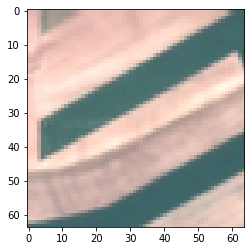

In [8]:
import matplotlib.pyplot as plt

# test the labels and images 
tmp = 3333
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

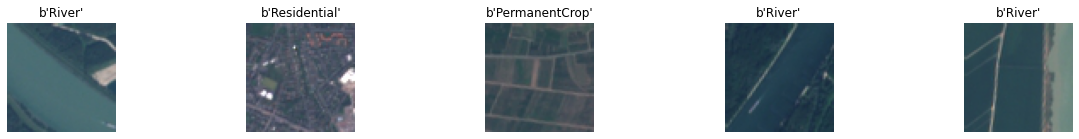

In [9]:
#Select a random sample of images and Plot

num_test_images = XImages.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = XImages[random_inx, ...]
random_test_labels = Ylabel[random_inx, ...]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(random_test_labels[i])
  ax[i].imshow(random_test_images[i])

In [10]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
smallest_class

5

In [11]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]
print(smallest_class_obs.shape)

(2000,)


In [12]:
shuffle(np.where(yLabels == i)[0], random_state=42).shape

(2500,)

In [13]:
shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]].shape

(2000,)

In [14]:
# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

In [15]:
indBal.shape

(20000,)

In [16]:
from sklearn.model_selection import train_test_split
#Unbalanced labels
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, test_size = 0.5, random_state=42)

b'Industrial'


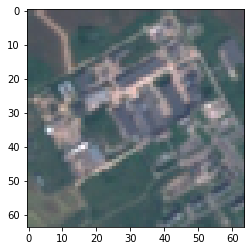

In [17]:
# test that the labels and images 
tmp = 3333
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img); 

In [18]:
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


In [19]:
#balanced labels
X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, test_size = 0.5, random_state=42)

b'Industrial'


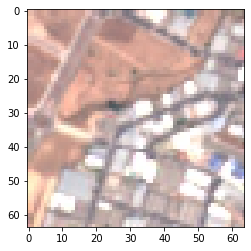

In [20]:
# test that the labels and images 
tmp = 3333
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [21]:
# Convert train and test images into 'float64' type

# train_images = train_images.astype('float64')
# test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [22]:
from tensorflow.keras.utils import to_categorical

# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_class_train = to_categorical(y_train, num_classes)
y_class_test = to_categorical(y_test, num_classes)

print(X_train.shape)
print(X_test.shape)
print(y_class_train.shape)
print(y_class_test.shape)

(10000, 64, 64, 3)
(10000, 64, 64, 3)
(10000, 10)
(10000, 10)


In [23]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


In [24]:
#or
X_train_BW = np.average(X_train, axis=-1)
X_test_BW = np.average(X_test, axis=-1)
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


 Label : b'Industrial'


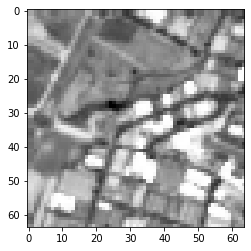

In [25]:
# test that the labels and images 
tmp = 3333
img = X_train_BW[tmp]

print(f' Label : {label_names[y_train[tmp]]}')
plt.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray') )

In [26]:
# Add a dummy channel dimension

my_image_train = X_train_BW[..., np.newaxis]
my_image_test = X_test_BW[..., np.newaxis]

from sklearn.preprocessing import LabelBinarizer


# One-hot encoding of train and test labels

# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.
lb = LabelBinarizer()
my_train_labels = lb.fit_transform(y_train)
my_test_labels = lb.fit_transform(y_test)

print(my_image_train.shape)
print (my_image_test.shape)
print(my_train_labels.shape)
print(my_test_labels.shape)

(10000, 64, 64, 1)
(10000, 64, 64, 1)
(10000, 10)
(10000, 10)


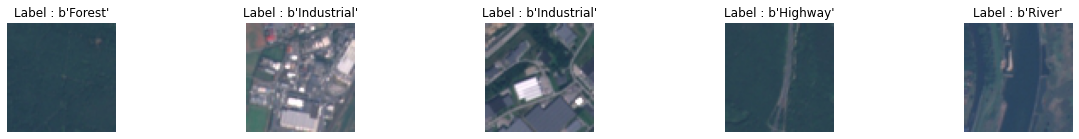

In [27]:
#Select a random sample of color images and Plot

num_test_images = X_train.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_train[random_inx, ...]
random_test_labels = y_train[random_inx, ...]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(f'Label : {label_names[random_test_labels[i]]}')
  ax[i].imshow(random_test_images[i])

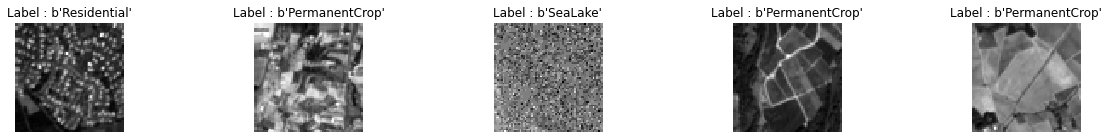

In [28]:
#Select a random sample of grey images and Plot

num_test_images = X_train_BW.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_train_BW[random_inx, ...]
random_test_labels = y_train[random_inx, ...]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(f'Label : {label_names[random_test_labels[i]]}')
  ax[i].imshow(random_test_images[i], interpolation='nearest', cmap=plt.get_cmap('gray'))

#Data for MLP model

In [29]:
from skimage.color import rgb2gray

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

print(X_train_BW.shape)
print(X_test_BW.shape)
print(y_class_train.shape)
print(y_class_test.shape)

(10000, 4096)
(10000, 4096)
(10000, 10)
(10000, 10)


#Build the model

**MLP neural network classifier** 

First model

In [31]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [32]:
def model_1(input_shape) :
  model_1 = Sequential()
  model_1.add(Dense(num_classes, activation = 'softmax', input_shape=(input_shape)))
  
  model_1.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_1

In [33]:
model_1 = model_1(X_train_BW[0].shape)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


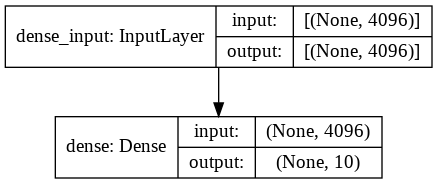

In [34]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import callbacks

checkpoint = ModelCheckpoint (filepath = 'checkpoint', monitor = 'val_loss',
                              save_beat_only = True, save_freq = 'epoch', verbose = 1)

In [36]:
history = model_1.fit(X_train_BW,y_class_train, validation_data= (X_test_BW, y_class_test) , 
                      batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

Epoch 1/100
157/157 [==============================] - 2s 6ms/step - loss: 2.2934 - categorical_accuracy: 0.1084 - val_loss: 2.2864 - val_categorical_accuracy: 0.1177

Epoch 00001: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2628 - categorical_accuracy: 0.1315 - val_loss: 2.2552 - val_categorical_accuracy: 0.1379

Epoch 00002: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2437 - categorical_accuracy: 0.1413 - val_loss: 2.2477 - val_categorical_accuracy: 0.1390

Epoch 00003: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2303 - categorical_accuracy: 0.1465 - val_loss: 2.2398 - val_categorical_accuracy: 0.1528

Epoch 00004: saving model to checkpoint
INFO:tens

In [37]:
score = model_1.evaluate(X_test_BW, y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 2.1160 - categorical_accuracy: 0.2563
Test loss: 2.1159896850585938
Test accuracy: 0.2563000023365021


In [38]:
frame = pd.DataFrame(history.history)
frame.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,2.293437,0.1084,2.286396,0.1177
1,2.262778,0.1315,2.255170,0.1379
2,2.243653,0.1413,2.247682,0.1390
3,2.230343,0.1465,2.239760,0.1528
4,2.221921,0.1536,2.229157,0.1447


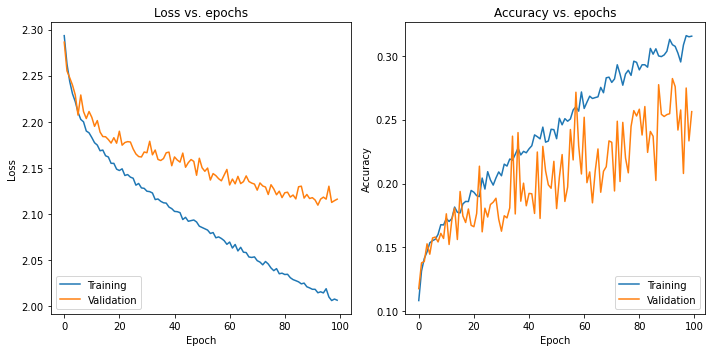

In [39]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [40]:
y_test_true_tmp = np.argmax(y_class_test, axis = 1)
label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [41]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

In [42]:
M1_pred_df = eval_model_by_class(model_1, X_test_BW)
M1_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',340,1000,0.340,0.2563
1,1,b'Forest',579,1000,0.579,0.2563
2,2,b'HerbaceousVegetation',61,1000,0.061,0.2563
3,3,b'Highway',205,1000,0.205,0.2563
4,4,b'Industrial',657,1000,0.657,0.2563
5,5,b'Pasture',0,1000,0.000,0.2563
6,6,b'PermanentCrop',114,1000,0.114,0.2563
7,7,b'Residential',176,1000,0.176,0.2563
8,8,b'River',431,1000,0.431,0.2563
9,9,b'SeaLake',0,1000,0.000,0.2563


In [43]:
M1_pred_wrong = find_wrong_preds(model_1, X_test_BW)
M1_pred_wrong

,y_true,y_pred,accurate_preds
702,b'AnnualCrop',b'AnnualCrop',True
5448,b'AnnualCrop',b'AnnualCrop',True
9648,b'AnnualCrop',b'Highway',False
5446,b'AnnualCrop',b'PermanentCrop',False
3077,b'AnnualCrop',b'AnnualCrop',True
...,...,...,...
1810,b'SeaLake',b'Forest',False
5438,b'SeaLake',b'AnnualCrop',False
5450,b'SeaLake',b'Highway',False
3137,b'SeaLake',b'Forest',False


#more

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40970     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 41,190
Trainable params: 41,190
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
157/157 [==============================] - 2s 10ms/step - loss: 2.3053 - categorical_accuracy: 0.1046 - val_loss: 2.3026 - val_categorical_accuracy: 0.1000

Epoch 00001: saving model to checkpoint
INFO:tensorflow:Assets written to:

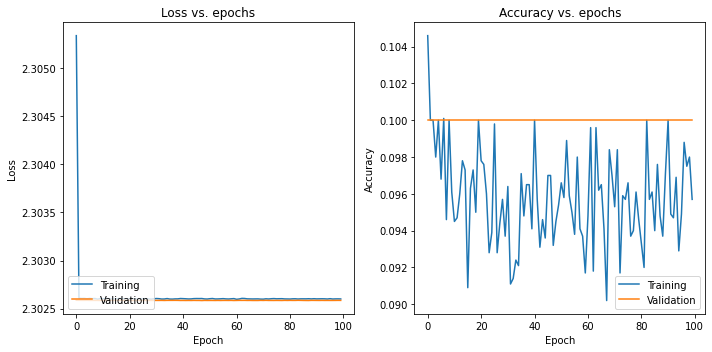

In [ ]:
def model_2(input_shape) :
  model_2 = Sequential()
  model_2.add(Dense(num_classes, activation = 'relu', name = 'dense_1', input_shape=(input_shape)))
  model_2.add(Dense(num_classes, activation = 'relu', name = 'dense_2'))
  model_2.add(Flatten())
  model_2.add(Dense(10, activation = 'softmax', name = 'dense_3'))
  
  model_2.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_2

model_2 = model_2(X_train_BW[0].shape)
print(model_2.summary())

history_2 = model_2.fit(X_train_BW,y_class_train, validation_data= (X_test_BW, y_class_test) , 
                      batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

frame_2 = pd.DataFrame(history.history)

score = model_2.evaluate(X_test_BW, y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_2.history['categorical_accuracy'])
plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
def model_3(input_shape, drop_rate, weight_decay_1, weight_decay_2) :
  model_3 = Sequential()
  model_3.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros', 
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2), input_shape=(input_shape), name = 'dense_1'))
  model_3.add(BatchNormalization(momentum=0.9, epsilon=0.0001))
  model_3.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros', 
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_2'))
  model_3.add(Dropout(drop_rate))
  model_3.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros', 
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_3'))
  model_3.add(Dropout(drop_rate))
  model_3.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros', 
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_4'))
  model_3.add(Dropout(drop_rate))
  model_3.add(Flatten(input_shape=(input_shape)))
  model_3.add(Dense(10, activation = 'softmax', name = 'dense_5'))
  
  model_3.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_3

model_3 = model_3(X_train_BW[0].shape, 0.3, 1e-8, 1e-5)
print(model_3.summary())

history_3 = model_3.fit(X_train_BW,y_class_train, validation_data= (X_test_BW, y_class_test) , 
                      batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

frame_3 = pd.DataFrame(history.history)

score = model_3.evaluate(X_test_BW, y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_3.history['categorical_accuracy'])
plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40970     
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [ ]:
def model_4(input_shape, drop_rate, weight_decay_1, weight_decay_2) :
  model_4 = Sequential()
  model_4.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2), input_shape=(input_shape), name = 'dense_1'))
  model_4.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_2'))
  model_4.add(Dense(num_classes, activation = 'relu',  kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_3'))
  model_4.add(Dropout(drop_rate))
  model_4.add(Dense(num_classes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01) , bias_initializer='zeros',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2),name = 'dense_4'))
  model_4.add(Dropout(drop_rate))
  model_4.add(Flatten(input_shape=(input_shape)))
  model_4.add(Dense(10, activation = 'softmax', name = 'dense_5'))
  
  model_4.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_4

model_4 = model_4(X_train_BW[0].shape, 0.3, 1e-8, 1e-5)
print(model_4.summary())

history_4 = model_4.fit(X_train_BW,y_class_train, validation_data= (X_test_BW, y_class_test) , 
                      batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

frame_4 = pd.DataFrame(history.history)

score = model_4.evaluate(X_test_BW, y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [ ]:
def model_5(input_shape) :
  model_5 = Sequential()
  model_5.add(Dense(256, activation = 'relu', input_shape=(input_shape), name = 'dense_1'))
  model_5.add(Dense(num_classes, activation = 'softmax', name = 'dense_2'))
  
  model_5.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_5

model_5 = model_5(X_train_BW[0].shape)
print(model_5.summary())

history_5 = model_5.fit(X_train_BW,y_class_train, validation_data= (X_test_BW, y_class_test) , 
                      batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

frame_5 = pd.DataFrame(history_5.history)

score = model_5.evaluate(X_test_BW, y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_5.history['categorical_accuracy'])
plt.plot(history_5.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

#Multihead CNN

In [44]:
# Shared Input Layer
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

In [45]:
X_train_BW.shape

(10000, 4096)

In [46]:
# one time series per head
n_features = 1
# separate input data
X1 = X_train_BW[:, :].reshape(X_train_BW.shape[0], X_train_BW.shape[1], n_features)
X2 = X_train_BW[:, :].reshape(X_train_BW.shape[0], X_train_BW.shape[1], n_features)
print(X1.shape, X2.shape)

(10000, 4096, 1) (10000, 4096, 1)


In [47]:
X1test = X_test_BW[:, :].reshape(X_test_BW.shape[0], X_test_BW.shape[1], n_features)
X2test = X_test_BW[:, :].reshape(X_test_BW.shape[0], X_test_BW.shape[1], n_features)
print(X1test.shape, X2test.shape)

(10000, 4096, 1) (10000, 4096, 1)


In [48]:
# first input model
head_1 = Input(shape=(X_train_BW[0].shape))
cnn1 = Dense(256, activation='relu')(head_1)
cnn1 = Flatten()(cnn1)


# second input model
head_2 = Input(shape=(X_train_BW[0].shape))
cnn2 = Dense(128, activation='relu')(head_2)
cnn2 = Flatten()(cnn2)

# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(64, activation='relu')(merge)
output = Dense(num_classes, activation='sigmoid')(dense)


model = Model(inputs=[head_1, head_2], outputs=output)
model.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
               loss = tf.keras.losses.CategoricalCrossentropy(), 
               metrics = [tf.keras.metrics.CategoricalAccuracy()])

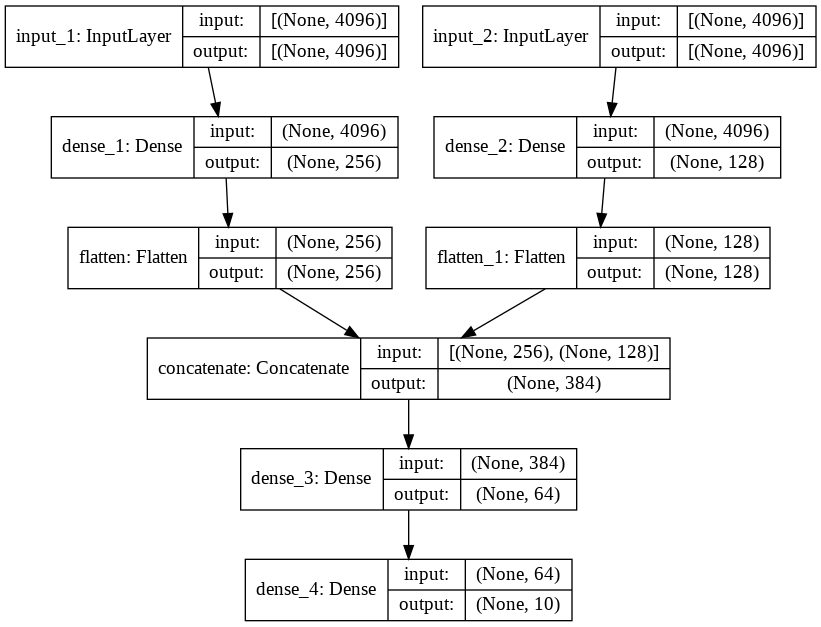

In [49]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [50]:
history_mul = model.fit([X1, X2],y_class_train, validation_data= ([X1test,X2test], y_class_test),batch_size=64 , epochs=100, callbacks=[checkpoint],  verbose=1)

score = model.evaluate([X1, X2], y_class_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Epoch 1/100
157/157 [==============================] - 4s 24ms/step - loss: 2.2828 - categorical_accuracy: 0.1198 - val_loss: 2.2676 - val_categorical_accuracy: 0.1231

Epoch 00001: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/100
157/157 [==============================] - 4s 23ms/step - loss: 2.2495 - categorical_accuracy: 0.1319 - val_loss: 2.2263 - val_categorical_accuracy: 0.1385

Epoch 00002: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/100
157/157 [==============================] - 3s 22ms/step - loss: 2.2128 - categorical_accuracy: 0.1431 - val_loss: 2.2198 - val_categorical_accuracy: 0.1573

Epoch 00003: saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/100
157/157 [==============================] - 3s 22ms/step - loss: 2.1901 - categorical_accuracy: 0.1472 - val_loss: 2.1896 - val_categorical_accuracy: 0.1582

Epoch 00004: saving model to checkpoint
INFO:

In [51]:
frame_mul = pd.DataFrame(history_mul.history)
frame_mul.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,2.282829,0.1198,2.267601,0.1231
1,2.249547,0.1319,2.226316,0.1385
2,2.212791,0.1431,2.219753,0.1573
3,2.190051,0.1472,2.189582,0.1582
4,2.174581,0.1482,2.176456,0.1486


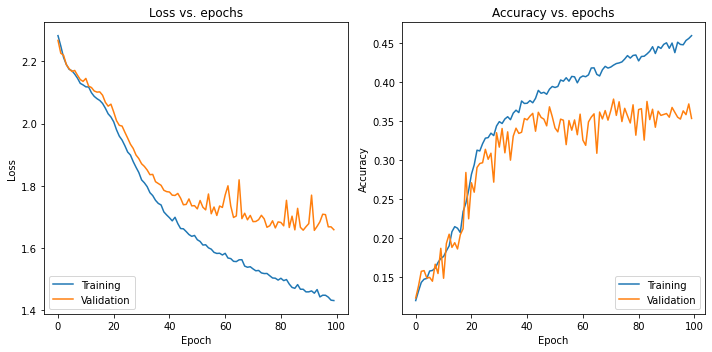

In [52]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_mul.history['loss'])
plt.plot(history_mul.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_mul.history['categorical_accuracy'])
plt.plot(history_mul.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [53]:
MM_pred_df = eval_model_by_class(model, [X1test,X2test])
MM_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',275,1000,0.275,0.3534
1,1,b'Forest',727,1000,0.727,0.3534
2,2,b'HerbaceousVegetation',61,1000,0.061,0.3534
3,3,b'Highway',301,1000,0.301,0.3534
4,4,b'Industrial',542,1000,0.542,0.3534
5,5,b'Pasture',169,1000,0.169,0.3534
6,6,b'PermanentCrop',419,1000,0.419,0.3534
7,7,b'Residential',313,1000,0.313,0.3534
8,8,b'River',458,1000,0.458,0.3534
9,9,b'SeaLake',269,1000,0.269,0.3534


In [54]:
MM_pred_wrong = find_wrong_preds(model, [X1test,X2test])
MM_pred_wrong

,y_true,y_pred,accurate_preds
702,b'AnnualCrop',b'AnnualCrop',True
5448,b'AnnualCrop',b'PermanentCrop',False
9648,b'AnnualCrop',b'SeaLake',False
5446,b'AnnualCrop',b'PermanentCrop',False
3077,b'AnnualCrop',b'Highway',False
...,...,...,...
1810,b'SeaLake',b'Forest',False
5438,b'SeaLake',b'SeaLake',True
5450,b'SeaLake',b'River',False
3137,b'SeaLake',b'Forest',False


#New Model

CNN model

In [55]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [56]:
checkpoint = ModelCheckpoint(filepath='/content/checkpoint/checkpoint001' , monitor = 'val_loss' ,
                             save_best_only=True, save_freq = 'epoch', verbose = 1 )

Early = EarlyStopping(monitor = 'val_loss', min_delta=10, patience=20, verbose = 1, 
                     mode = 'max', restore_best_weights=True)

Re = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 20, verbose = 1,
                       mode = 'max' , min_delta=0.0001, cooldown=0, min_lr=0)

callback = [checkpoint, Early, Re]

In [57]:
def model_6(input_shape, weight_decay_1, weight_decay_2, drop_rate) :
  model_6 = Sequential()
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_1', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2), input_shape = input_shape))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_2', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_6.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_1'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_3', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_4', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_6.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_2'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_5'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_6'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_7'))
  model_6.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_3'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_8'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_9'))
  model_6.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_10'))
  model_6.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_4'))
  model_6.add (Flatten ())
  model_6.add (Dropout(rate = drop_rate))
  model_6.add (Dense (512, activation = 'relu',  name = 'dense_1') )
  model_6.add (Dense (num_classes, activation = 'softmax', name = 'dense_2') )
  
  model_6.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
  
  return model_6

model_6 = model_6(my_image_train[0].shape, 1e-8, 0.0001, 0.05)
model_6.summary()

history_6 = model_6.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , 
                        batch_size=64, epochs=100, callbacks=callback, verbose=1)

score = model_6.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 16)        2320      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 31, 31, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 31, 31, 16)        2320      
_________________________________________________________________
conv_4 (Conv2D)              (None, 31, 31, 16)        2320      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 14, 14, 16)       

In [58]:
frame_6 = pd.DataFrame(history_6.history)
frame_6.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr
0,2.060721,0.2111,1.829662,0.2567,0.0001
1,1.803305,0.2771,1.758472,0.2796,0.0001
2,1.728069,0.3175,1.666558,0.3311,0.0001
3,1.610933,0.3720,1.501054,0.4476,0.0001
4,1.455486,0.4424,1.370284,0.4791,0.0001


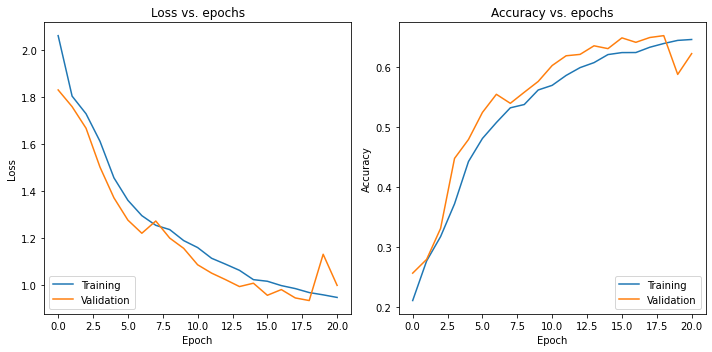

In [59]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_6.history['categorical_accuracy'])
plt.plot(history_6.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
M6_pred_df = eval_model_by_class(model_6, my_image_test)
M6_pred_wrong = find_wrong_preds(model_6, my_image_test)

print(M6_pred_df)
print(M6_pred_wrong)

In [60]:
from tensorflow.keras.applications import vgg16

conv_base = vgg16.VGG16(include_top=False, weights=None, input_shape = (my_image_train[0].shape))

In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
def model_7(input_shape, drop_rate) :
  model_7 = Sequential()
  model_7.add (conv_base)

  model_7.add (Flatten ())
  model_7.add (Dropout(rate = drop_rate))
  model_7.add (Dense (512, activation = 'relu',  name = 'dense_1') )
  model_7.add (Dense (num_classes, activation = 'softmax', name = 'dense_2') )
  
  model_7.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
  
  return model_7

model_7 = model_7(my_image_train[0].shape, 0.3)
model_7.summary()

history_7 = model_7.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , 
                        batch_size=64, epochs=100, callbacks=callback, verbose=1)

score = model_7.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
M6_pred_df = eval_model_by_class(model_6, my_image_test)
M6_pred_wrong = find_wrong_preds(model_6, my_image_test)

print(M6_pred_df)
print(M6_pred_wrong)

#Fourth model

In [ ]:
def model_4 (input_shape) :
  model_4 = Sequential ()
  model_4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(64, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(128, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(256, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Flatten())
  model_4.add(Dropout(0.5))
  model_4.add(Dense(512, activation='relu'))
  model_4.add(Dense(num_classes, activation='softmax'))

  model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  return model_4 

In [ ]:
model_4 = model_4(my_image_train[0].shape)
model_4.summary()

In [ ]:
history_4 = model_4.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , 
                        batch_size=64, epochs=100, callbacks=call, verbose=1)

In [ ]:
score = model_4.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
frame_4 = pd.DataFrame(history_4.history)
frame_4.head()

In [ ]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
M2_pred_df_4 = eval_model_by_class(model_4, my_image_test)
M2_pred_df_4

In [ ]:
from keras.utils import plot_model
plot_convolutional_filters(img)

In [ ]:
import tensorflow_datasets.public_api as tfds

tfds.list_builders()